## Different packages for processing different data types

Generally, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

    For images, packages such as Pillow, OpenCV are useful

    For audio, packages such as scipy and librosa

    For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called torchvision, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc, which are accessible via `torchvision.datasets`. It also has a number of transforms that can be applied to images, such as resizing, cropping, normalization, etc., which are accessible via `torchvision.transforms`.


For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier on CIFAR10

We will do the following steps in order:

    1. Load and normalize the CIFAR10 training and test datasets using torchvision
    2. Define a Convolutional Neural Network
    3. Define a loss function
    4. Train the network on the training data
    5. Test the network on the test data


### Load and normalize the CIFAR10 dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Now let's load torchvision datasets, whicha are PILImage images of range [0, 1], and we can transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:20<00:00, 8394781.36it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's plot some training images to get familiar with the dataset.

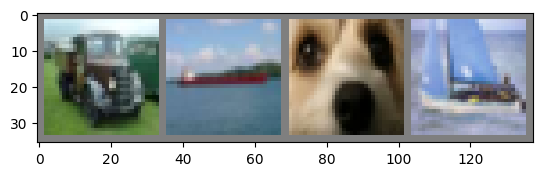

truck ship  dog   ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images as input.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Define loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.264
[1,  4000] loss: 1.949
[1,  6000] loss: 1.734
[1,  8000] loss: 1.609
[1, 10000] loss: 1.531
[1, 12000] loss: 1.454
[2,  2000] loss: 1.409
[2,  4000] loss: 1.348
[2,  6000] loss: 1.333
[2,  8000] loss: 1.341
[2, 10000] loss: 1.286
[2, 12000] loss: 1.270
Finished Training


Save the trained model.

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

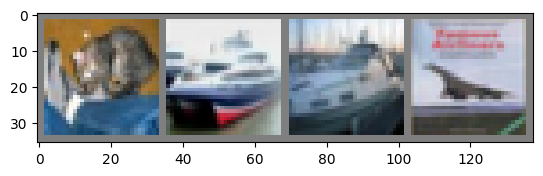

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Load the network from the saved model and test it on the test dataset.

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

Test the model on a small test data

In [9]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Now let's test on the whole test dataset.

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


Let's print accuracy for each class of the CIFAR10 dataset.

In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.2 %
Accuracy for class: car   is 55.7 %
Accuracy for class: bird  is 45.1 %
Accuracy for class: cat   is 52.0 %
Accuracy for class: deer  is 18.1 %
Accuracy for class: dog   is 31.4 %
Accuracy for class: frog  is 73.0 %
Accuracy for class: horse is 59.6 %
Accuracy for class: ship  is 71.3 %
Accuracy for class: truck is 78.1 %


### Move the model to the GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cpu


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
inputs, labels = data[0].to(device), data[1].to(device)